In [1]:
from pyuvdata.uvdata.mir_parser import MirParser
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as o
from scipy import signal
from lmfit.models import LinearModel, LorentzianModel
import scipy.linalg as linalg

In [23]:
def clean(iterations, min_freq, data):
    #Local copy
    data = 1 * data

    #Remove residual baselines
    data -= np.nanmedian(data, axis=1) #I think this is right?
    
    #Padding size -- don't do anything if the data are already a 2^n size
    if (data.shape[1] & (data.shape[1] - 1)) == 0:
        highest_n = int(np.log10(data.shape[1]) / np.log10(2))
        
    else:
        highest_n = int(np.ceil(np.log10(data.shape[1]) / np.log10(2)) + 2)

    #Stores final model and residual arrays
    model_fin = np.zeros((data.shape[0], 2**highest_n), dtype='complex128')
    resid_fin = np.zeros((data.shape[0], 2**highest_n), dtype='complex128')
    
    #Stores *actual* FFT frequencies for model below
    fftfreqs  = np.fft.fftfreq(int(2**highest_n), d = np.abs(np.diff(f_sky)[0])) 
    
    for integ in range(data.shape[0]):
        
        #Data -- Pad integration time
        padded_integ = np.pad(data[integ, :], (0, 2**highest_n - data[integ, :].size))

        #Residual, i.e., = padded data - padded model, initialized to padded data since there's no model
        resid_init = 1 * np.fft.fft(padded_integ)
        plt.plot(fftfreqs, np.abs(resid_init)**2.0)
        
        resid = 1 * resid_init
        
        #Model -- Padded model 
        model = np.zeros(padded_integ.size, dtype='complex128')
        model_fft = np.zeros(resid.size, dtype='complex128')
        
        for step in range(iterations):
            
            #Find peak ABSOLUTE FFT amplitude
            resid_psd = np.abs(resid)**2.0
            peak_amp_pos = np.nanmax(resid_psd[fftfreqs >= min_freq])
            peak_amp_neg = np.nanmax(resid_psd[fftfreqs <= -min_freq])
            
            #Find peak FFT frequency
            peak_base_pos = np.flatnonzero(np.isclose(resid_psd, peak_amp_pos))[0]
            peak_base_neg = np.flatnonzero(np.isclose(resid_psd, peak_amp_neg))[0]
            
            #Model from FFT peak above
            model_fft[peak_base_pos] += resid[peak_base_pos].real + 1j * resid[peak_base_pos].imag
            model_fft[peak_base_neg] += resid[peak_base_neg].real + 1j * resid[peak_base_neg].imag

            model = np.fft.ifft(model_fft, n = 2**highest_n)
            model[np.isclose(padded_integ, 0)] = 0

            resid = np.fft.fft(padded_integ - model.real)
            
        #TODO: Stopping criteria?
        #plt.plot(fftfreqs, np.abs(resid)**2.0)
        #plt.xscale('symlog')
        #plt.yscale('log')
        #plt.show()

        #plt.plot(model.imag.flatten()[:14336], 'k--')
        #plt.plot(model.real.flatten()[:14336], 'r,-')
        #plt.xlim(0, 2000)
        #plt.show()
        
        #Store model
        model_fin[integ, :] = 1 * np.fft.ifft(model_fft, n=2**highest_n).real
        resid_fin[integ, :] = 1 * resid
    return model_fin, resid_fin

In [29]:
def poly_expansion(data, num_comps, min_freq, polyorder = 5):
    #Local copy
    data = 1 * data

    #Remove residual baselines
    data -= np.nanmedian(data, axis=1) #I think this is right?
    
    #Padding size -- don't do anything if the data are already a 2^n size
    if (data.shape[1] & (data.shape[1] - 1)) == 0:
        highest_n = int(np.log10(data.shape[1]) / np.log10(2))
        
    else:
        highest_n = int(np.ceil(np.log10(data.shape[1]) / np.log10(2)) + 2)

    #Stores final model and residual arrays
    model_fin = np.zeros((data.shape[0], 2**highest_n), dtype='complex128')
    resid_fin = np.zeros((data.shape[0], 2**highest_n), dtype='complex128')
    model_store = np.zeros((data.shape[0], 2**highest_n))
                            
    #Stores *actual* FFT frequencies for model below
    fftfreqs  = np.fft.fftfreq(int(2**highest_n), d = np.abs(np.diff(f_sky)[0])) 
    
    freqs_pad = f_sky[0] + np.diff(f_sky)[0] * np.arange(0, 2**highest_n)
    
    f_sky_norm = 2 * (freqs_pad - freqs_pad.min()) / (freqs_pad.max() - freqs_pad.min()) - 1
    
    for integ in range(data.shape[0]):
        
        #Data -- Pad integration time
        padded_integ = np.pad(data[integ, :], (0, 2**highest_n - data[integ, :].size))

        #Residual, i.e., = padded data - padded model, initialized to padded data since there's no model
        resid_init = 1 * np.fft.fft(padded_integ)
        
        resid = 1 * resid_init
        
        #Model -- Padded model 
        model = np.zeros(padded_integ.size, dtype='complex128')

        for _ in range(num_comps):
            model_fft = np.zeros(resid.size, dtype='complex128')
            #Find peak ABSOLUTE FFT amplitude
            resid_psd = np.abs(resid)**2.0
            
            peak_amp_pos = np.nanmax(resid_psd[fftfreqs >= min_freq])
            peak_amp_neg = np.nanmax(resid_psd[fftfreqs <= -min_freq])
            
            #Find peak FFT frequency
            peak_base_pos = np.flatnonzero(np.isclose(resid_psd, peak_amp_pos))[0]
            peak_base_neg = np.flatnonzero(np.isclose(resid_psd, peak_amp_neg))[0]
            #print(fftfreqs[peak_base_pos])
            
            #Model from FFT peak above
            model_fft[[peak_base_pos, peak_base_neg]] = 1*resid[[peak_base_pos, peak_base_neg]]
            
            #model = np.fft.ifft(model_fft, n = 2**highest_n)
            model_sin = np.fft.ifft(model_fft.imag * 1j, n = 2**highest_n)
            model_cos = np.fft.ifft(model_fft.real,      n = 2**highest_n)
    
            model_sin[np.isclose(padded_integ, 0)] = 0
            model_cos[np.isclose(padded_integ, 0)] = 0

            #Now, implement polynomial expansion fitting
            b = padded_integ - model_store[integ, :]
            
            #plt.plot(b.flatten())
            
            A = np.zeros((padded_integ.size, 2 * polyorder))
            
            for basis in range(polyorder):
                A[:, basis * 2] = model_sin.real * f_sky_norm**(basis)
                A[:, (basis * 2) + 1] = model_cos.real * f_sky_norm**(basis)
    
            res = linalg.lstsq(A, b)
            #print(res[1:])
            polyvalues = res[0]
            model_store[integ, :] += np.matmul(A, polyvalues)
            
            resid = np.fft.fft(padded_integ - model_store[integ, :])
            
            #plt.plot(model_store.flatten())
            #print(polyvalues)
        #plt.xlim(0, 14336)
        #plt.show()
        # plt.xlim(0, 2000)
        # plt.show()
        #plt.plot(freqs_pad, padded_integ.flatten())
        #plt.plot(freqs_pad, model_store.flatten())
        #plt.plot(freqs_pad, padded_integ.flatten() - model_store.flatten())
        #plt.xlim(f_sky.min(), f_sky.max())
        #plt.xlim(235.65,235.85)
        #plt.xlim(236.05, 236.15)
        #plt.show()

        #plt.figure(figsize=(10, 10))
        #plt.loglog(fftfreqs, np.abs(np.fft.fft(padded_integ - model_store[integ, :])**2.0))#, label="First fit")
        #for i in range(11):
            #plt.axvline(6.28 * 46.7 * i, color='k', ls='--')
            #plt.axvline(17.8 * i * 6.28, color='r', ls='-.')
            #plt.axvline(63.1 * i * 6.28, color='g', ls=':')
        #plt.loglog(fftfreqs, np.abs(np.fft.fft(padded_integ)**2.0), label="Original", alpha=0.35)
        #plt.ylim(1e-4, 1e2)
        #plt.xlim(50, 1000)
        #plt.legend()
        #plt.show()
    return model_store

In [4]:
def poly_expansion_prior(data, num_comps, f0, polyorder = 5, fft_window = 20):
    #Local copy
    data = 1 * data

    #Remove residual baselines
    data -= np.nanmedian(data, axis=1) #I think this is right?
    
    #Padding size -- don't do anything if the data are already a 2^n size
    if (data.shape[1] & (data.shape[1] - 1)) == 0:
        highest_n = int(np.log10(data.shape[1]) / np.log10(2))
        
    else:
        highest_n = int(np.ceil(np.log10(data.shape[1]) / np.log10(2)) + 2)

    #Stores final model and residual arrays
    #model_fin = np.zeros((data.shape[0], 2**highest_n), dtype='complex128')
    #resid_fin = np.zeros((data.shape[0], 2**highest_n), dtype='complex128')
    model_store = np.zeros(data.shape)
                            
    #Stores *actual* FFT frequencies for model below
    fftfreqs  = np.fft.fftfreq(int(2**highest_n), d = np.abs(np.diff(f_sky)[0])) 
    
    freqs_pad = f_sky[0] + np.diff(f_sky)[0] * np.arange(0, 2**highest_n)
    
    f_sky_norm = 2 * (freqs_pad - freqs_pad.min()) / (freqs_pad.max() - freqs_pad.min()) - 1
    
    for integ in range(data.shape[0]):
        #Data -- Pad integration time
        padded_integ = np.pad(data[integ, :], (0, 2**highest_n - data[integ, :].size))

        #Padded FFT
        padded_fft = 1 * np.fft.fft(padded_integ)
        
        #Model -- Padded model 
        model = np.zeros(padded_integ.size, dtype='complex128')
        fitting_mask = np.nonzero(padded_integ)
        A = np.zeros((padded_integ.size, 2 * (polyorder + 1) * num_comps))
        #A_fin = np.zeros((padded_integ.size, 2 * (polyorder + 1) * num_comps))
        
        psd = np.abs(padded_fft)**2.0
        
        for harmonic in range(num_comps):
            model_fft = np.zeros(padded_fft.size, dtype='complex128')
            
            #Make window around |f0 * (1 + harmonic)| to search for peaks using a priori information
            fft_window_pos = np.greater_equal(fftfreqs, f0 * (harmonic + 1) - fft_window) & \
                             np.less_equal(fftfreqs, f0 * (harmonic + 1) + fft_window)
            
            fft_window_neg = np.greater_equal(fftfreqs, -f0 * (harmonic + 1) - fft_window) & \
                             np.less_equal(fftfreqs, -f0 * (harmonic + 1) + fft_window)
            
            peak_amp_pos = np.nanmax(psd[fft_window_pos])
            peak_amp_neg = np.nanmax(psd[fft_window_neg])
            
            #Find peak FFT frequency
            #Make smarter so that the chosen peaks correspond to pos/neg frequencies...
            peak_base_pos = np.flatnonzero(np.isclose(psd, peak_amp_pos))[0]
            peak_base_neg = np.flatnonzero(np.isclose(psd, peak_amp_neg))[1]
            
            #Model from FFT peak above
            model_fft[[peak_base_pos, peak_base_neg]] = 1*padded_fft[[peak_base_pos, peak_base_neg]]

            model_re = np.fft.ifft(model_fft.real,      n = 2**highest_n)
            model_im = np.fft.ifft(model_fft.imag * 1j, n = 2**highest_n)

            #In reality, I don't want to mask these; I want the masked channels to be taken out of the fit so that I can
            #interpolate later on
            #model_re[np.isclose(padded_integ, 0)] = 0
            #model_im[np.isclose(padded_integ, 0)] = 0           
            
            for basis in range(polyorder + 1):
                A[:, 2 * harmonic * (polyorder + 1) + 2 * basis]     = model_im.real * f_sky_norm**basis
                A[:, 2 * harmonic * (polyorder + 1) + 2 * basis + 1] = model_re.real * f_sky_norm**basis
        
        print(A[fitting_mask, :][0].shape)
        #b is the actual data, so no need to calculate residual
        res = linalg.lstsq(A[fitting_mask, :][0], padded_integ[fitting_mask])
        #print(res[1:])
        polyvalues = res[0]
        model_store[integ, :] = np.matmul(A, polyvalues)[:data.shape[1]]
        
        plt.plot(np.matmul(A, polyvalues)[:14336])
        plt.plot(padded_integ[:14336])
        #plt.plot(f_sky_norm, np.matmul(A_fin, polyvalues))
        #plt.plot(f_sky_norm[fitting_mask], padded_integ[fitting_mask])
        plt.xlim(0, 14336)
        plt.show()
        
    return model_store

# Import data

In [5]:
mir_data = MirParser("/home/jmichail/Desktop/OzoneData/211009_04:56:19", has_auto=True)

In [6]:
mir_data.unload_data()
mir_data.select(
    where=[
        ("sb", "eq", "u"),
        ("corrchunk","eq",4),
        ("ant", "eq",1),
        ("antrx","eq",0),
    ],
    reset=True
)
mir_data.load_data(load_auto=True, apply_tsys=False)

f_sky = (
    mir_data.ac_data['fsky'][0]
    + (np.arange(mir_data.ac_data['nch'][0]) - np.arange(mir_data.ac_data['nch'][0])/2)*mir_data.ac_data['fres'][0]*1e-3
)
f_sky = f_sky[1024:-1024]

In [7]:
sort_idx = np.argsort(mir_data.eng_data['actual_el'])

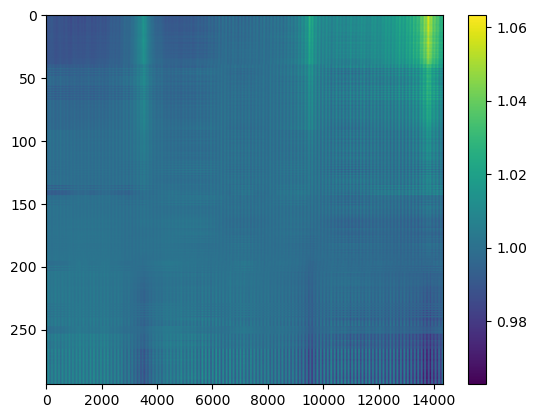

In [8]:
data_stack = np.vstack([item['data'] for item in mir_data.auto_data.values()])[:, 1024:-1024]
n_int, n_chan = data_stack.shape

data_stack = data_stack/np.repeat(np.median(data_stack,axis=0).reshape([1,-1]), n_int, axis=0)
data_stack = data_stack/np.repeat(np.median(data_stack,axis=1).reshape([-1,1]), n_chan, axis=1)

plt.imshow(data_stack[sort_idx, :], aspect='auto')
plt.colorbar()

# Manual Line Masking

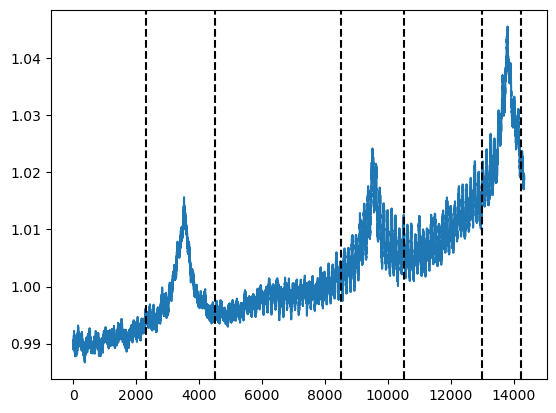

In [9]:
plt.plot(data_stack[50, :])
plt.axvline(2300, color='k', ls='--')
plt.axvline(4500, color='k', ls='--')
plt.axvline(8500, color='k', ls='--')
plt.axvline(10500, color='k', ls='--')
plt.axvline(13000, color='k', ls='--')
plt.axvline(data_stack[50, :].size-100, color='k', ls='--')

In [10]:
working_spec = 1 * data_stack
final_spec   = 1 * data_stack

ranges = [[2300, 4500], [8500, 10500], [13000, data_stack[50, :].size-5]]

baseline_indices = np.hstack([np.arange(0, 2300), np.arange(4500, 8500), np.arange(10500, 13000), np.arange(data_stack.shape[1]-100, data_stack.shape[1])])

for row in range(working_spec.shape[0]):
    p = np.polyfit(baseline_indices, data_stack[row, baseline_indices], 5)
    fit = np.poly1d(p)
    working_spec[row, baseline_indices] = data_stack[row, baseline_indices] - fit(baseline_indices)
    working_spec[row, baseline_indices] -= np.nanmean(working_spec[row, baseline_indices])

    final_spec[row, :] = data_stack[row, :] - fit(np.arange(data_stack.shape[1]))
    
    #Now mask lines regions
    for range_i in ranges:
        low, high = range_i[0], range_i[1]
        working_spec[row , low : high] = 0

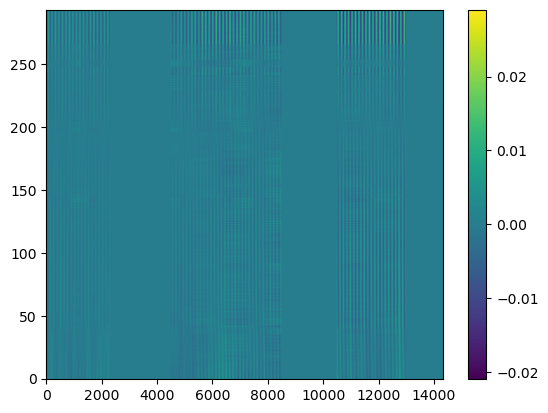

In [11]:
plt.imshow(working_spec[sort_idx, :], origin='lower', aspect='auto')
plt.colorbar()

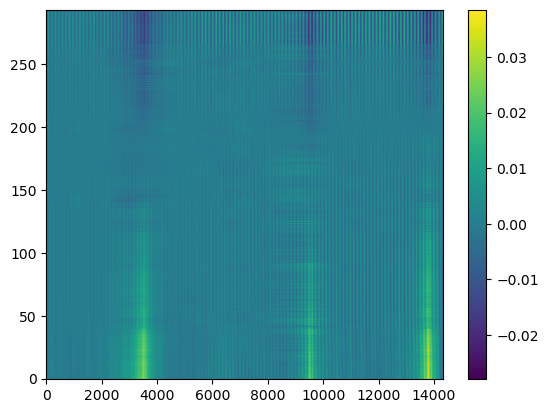

In [12]:
plt.imshow(final_spec[sort_idx, :], origin='lower', aspect='auto')
plt.colorbar()

# CLEAN method

In [53]:
for i in range(working_spec.shape[0]):
    if i % 20 == 0:
        print("%g / %g" % (i, working_spec.shape[0]))
    mod, resid = clean(2000, 5, working_spec[i].reshape((1, working_spec[i].size)))
    final_spec[i, :] -= mod[0, :14336].real

0 / 294
20 / 294
40 / 294
60 / 294
80 / 294
100 / 294
120 / 294
140 / 294
160 / 294
180 / 294
200 / 294
220 / 294
240 / 294
260 / 294
280 / 294


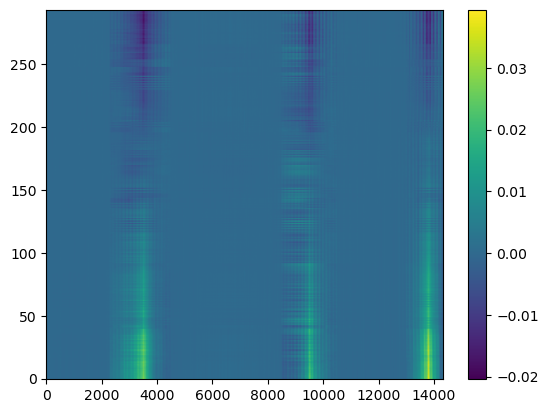

In [54]:
plt.imshow(final_spec[sort_idx, :], origin='lower', aspect='auto')
plt.colorbar()

(235.65, 235.85)

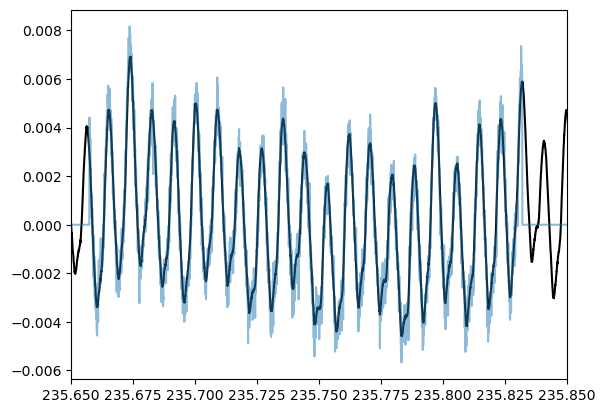

In [39]:
freqs_pad = f_sky[0] + np.diff(f_sky)[0] * np.arange(0, mod.size)
plt.plot(freqs_pad, mod[0, :], color='k')
plt.plot(f_sky, working_spec[50], alpha=0.5)
plt.xlim(235.65, 235.85)

(2000.0, 4000.0)

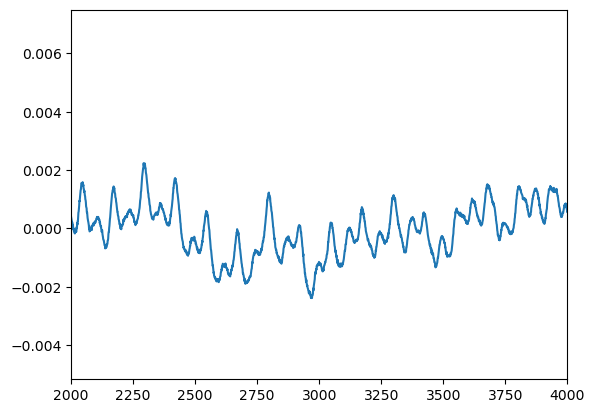

In [40]:
plt.plot(mod[0, :14336])
plt.xlim(2000, 4000)

(235.55, 235.65)

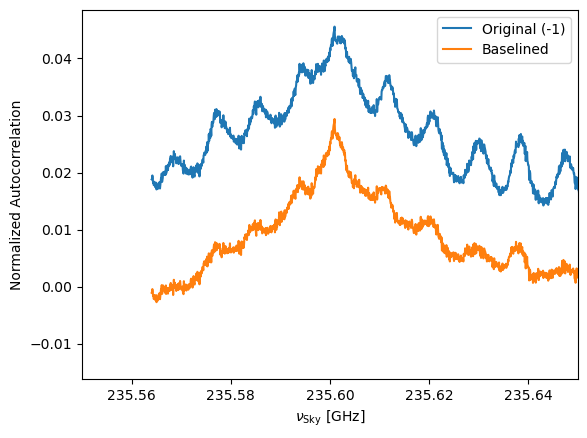

In [59]:
plt.plot(f_sky, data_stack[50, :]-1, label = "Original (-1)")
plt.plot(f_sky, final_spec[50, :], label = "Baselined")
#plt.plot(f_sky, final_spec[50, :] - mod[0, :14336], label="FFT Subtracted")
plt.legend()
plt.xlabel("$\\nu_{\\rm{Sky}}$ [GHz]")
plt.ylabel("Normalized Autocorrelation")
plt.xlim(235.55, 235.65)

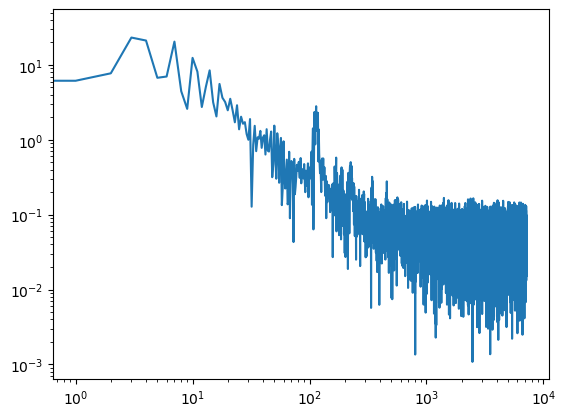

In [62]:
plt.loglog(np.abs(np.fft.rfft(final_spec[50, :].real)))
plt.show()

# CLEAN + LSQ Frankenstein method

In [30]:
poly_model = poly_expansion(working_spec[50].reshape((1, working_spec[50].size)), 10, 60, 6)

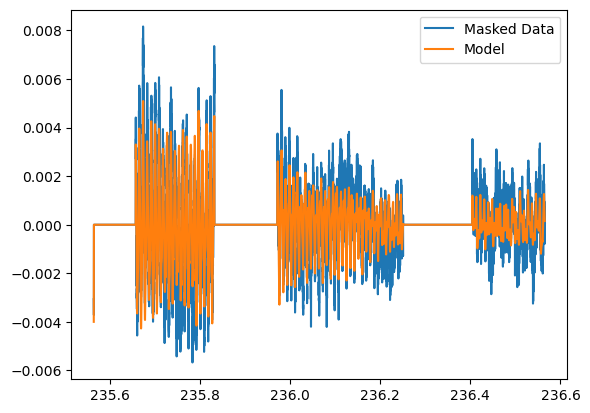

In [35]:
plt.plot(f_sky, working_spec[50], label = "Masked Data")
plt.plot(f_sky, poly_model.flatten()[:14336], label = "Model")
plt.legend()
plt.show()

# LSQ Method

(8805, 144)


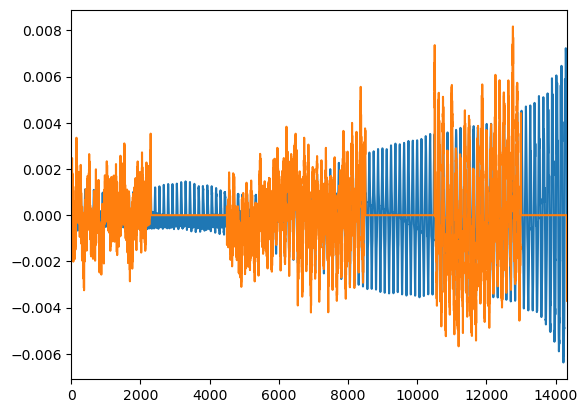

In [13]:
model = poly_expansion_prior(working_spec[50].reshape((1, working_spec[50].size)), 12, 2 * np.pi * 17.8, 5)

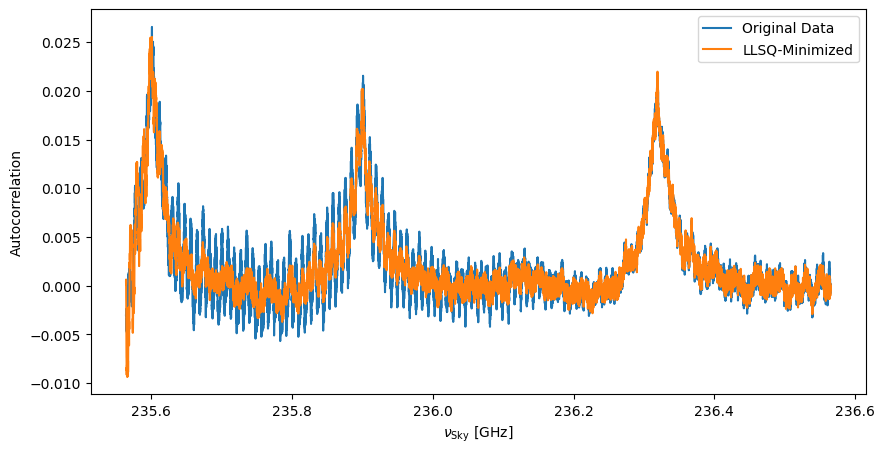

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(f_sky, final_spec[50], label="Original Data")
plt.plot(f_sky, final_spec[50] - model.flatten(), label = "LLSQ-Minimized")
plt.xlabel("$\\nu_{\\rm{Sky}}$ [GHz]")
plt.ylabel("Autocorrelation")
plt.legend()
#plt.plot(f_sky, final_spec[50])
#plt.xlim(f_sky.min(), 235.7)
#plt.xlim(235.8, 236.)
plt.show()

In [19]:
mod = 1 * model.flatten()

mod_zeroed = 1 * mod
mod_zeroed[np.isclose(working_spec[50], 0)] = 0

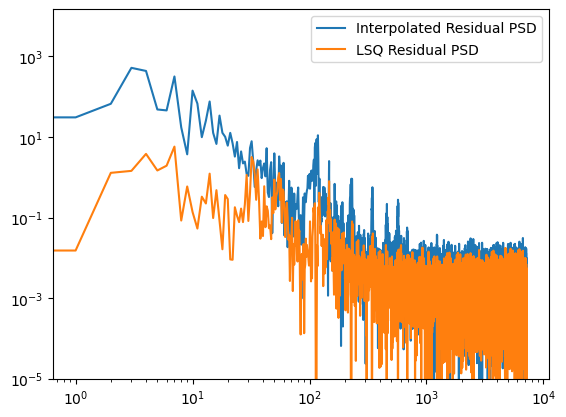

In [22]:
plt.loglog(np.abs(np.fft.rfft(final_spec[50] - mod))**2.0, label="Interpolated Residual PSD")
plt.loglog(np.abs(np.fft.rfft(working_spec[50] - mod_zeroed))**2.0, label="LSQ Residual PSD")
plt.ylim(ymin=1e-5)
plt.legend()
plt.show()